# Graph Theoretical Analysis on data collected during EPM experiment on DRD87

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from analysis import sig_proc
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
3. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
4. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
5. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
6. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
7. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
8. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


### We begin by doing the following: 
1. Importing the raw neuron signal data for DRD87 and run it through the Dombeck 2007 Signal Processing Algorithm.
2. Import the behavior data file for DRD87.
3. Create a new `FeatureExtractor` object by passing it DRD87's processed neuron signal dataframes returned by signal processing algorithm, and DRD87's corresponding behavior dataframe.
4. Finally, we shorten the neuron column vector names in the `cell_transients_dataframe` for DRD87 by removing everything but the neuron number. Note that this is not necessary, we only do this in order to make the graphs neater. 

In [4]:
drd87_data = pd.read_csv(raw_files[2], header=None)
_, auc_dataframe, cell_transients_dataframe = sig_proc.detect_ca_transients_mossy(drd87_data, 2, 0.5, 0.2, 10)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[0], header=None)
drd87_fe = FeatureExtractor(cell_transients_df=cell_transients_dataframe, auc_df=auc_dataframe, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd87_fe.cell_transients_df.columns = [i for i in range(1, len(drd87_fe.cell_transients_df.columns)+1)]

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:26: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



### Now, we read in the cartesian coordinates of the neurons in the DRD87's imaged network of neurons.

In [5]:
coordinates = pd.read_csv("~/Hen_Lab/Mice/DRD87_NO_OFT_POPP_reg/EPM_NO_OFT_POPP_centroids.csv" ,header=None)
coordinates.columns = ['x', 'y']

# Reset the index so that it starts from 1, since we refer to neurons as neurons 1, 2, ..., n
coordinates.index = pd.RangeIndex(1, len(coordinates.index)+1)

### We use the `get_neuron_positions()` function in order to generate a position dictionary of the cartesian coordinates for each neuron in DRD87's network of neurons. 

In [6]:
def get_neuron_positions(neuron_network, coordinates_df):
    pos = dict()

    for neuron in neuron_network.neurons:
        if neuron not in pos:
            pos[neuron] = (coordinates_df.loc[neuron, :]["x"], -coordinates_df.loc[neuron, :]["y"])
            
    return pos

In [7]:
def get_behavior_graph(feature_extractor, behavior):   
    indices = feature_extractor.neuron_concated_behavior.loc[feature_extractor.neuron_concated_behavior[behavior] != 0].index
    graph = NeuronNetwork(feature_extractor.cell_transients_df.iloc[indices])
    return graph

### We plot the network of neurons that were imaged in DRD87, for the *entire* duration of the EPM experiment.

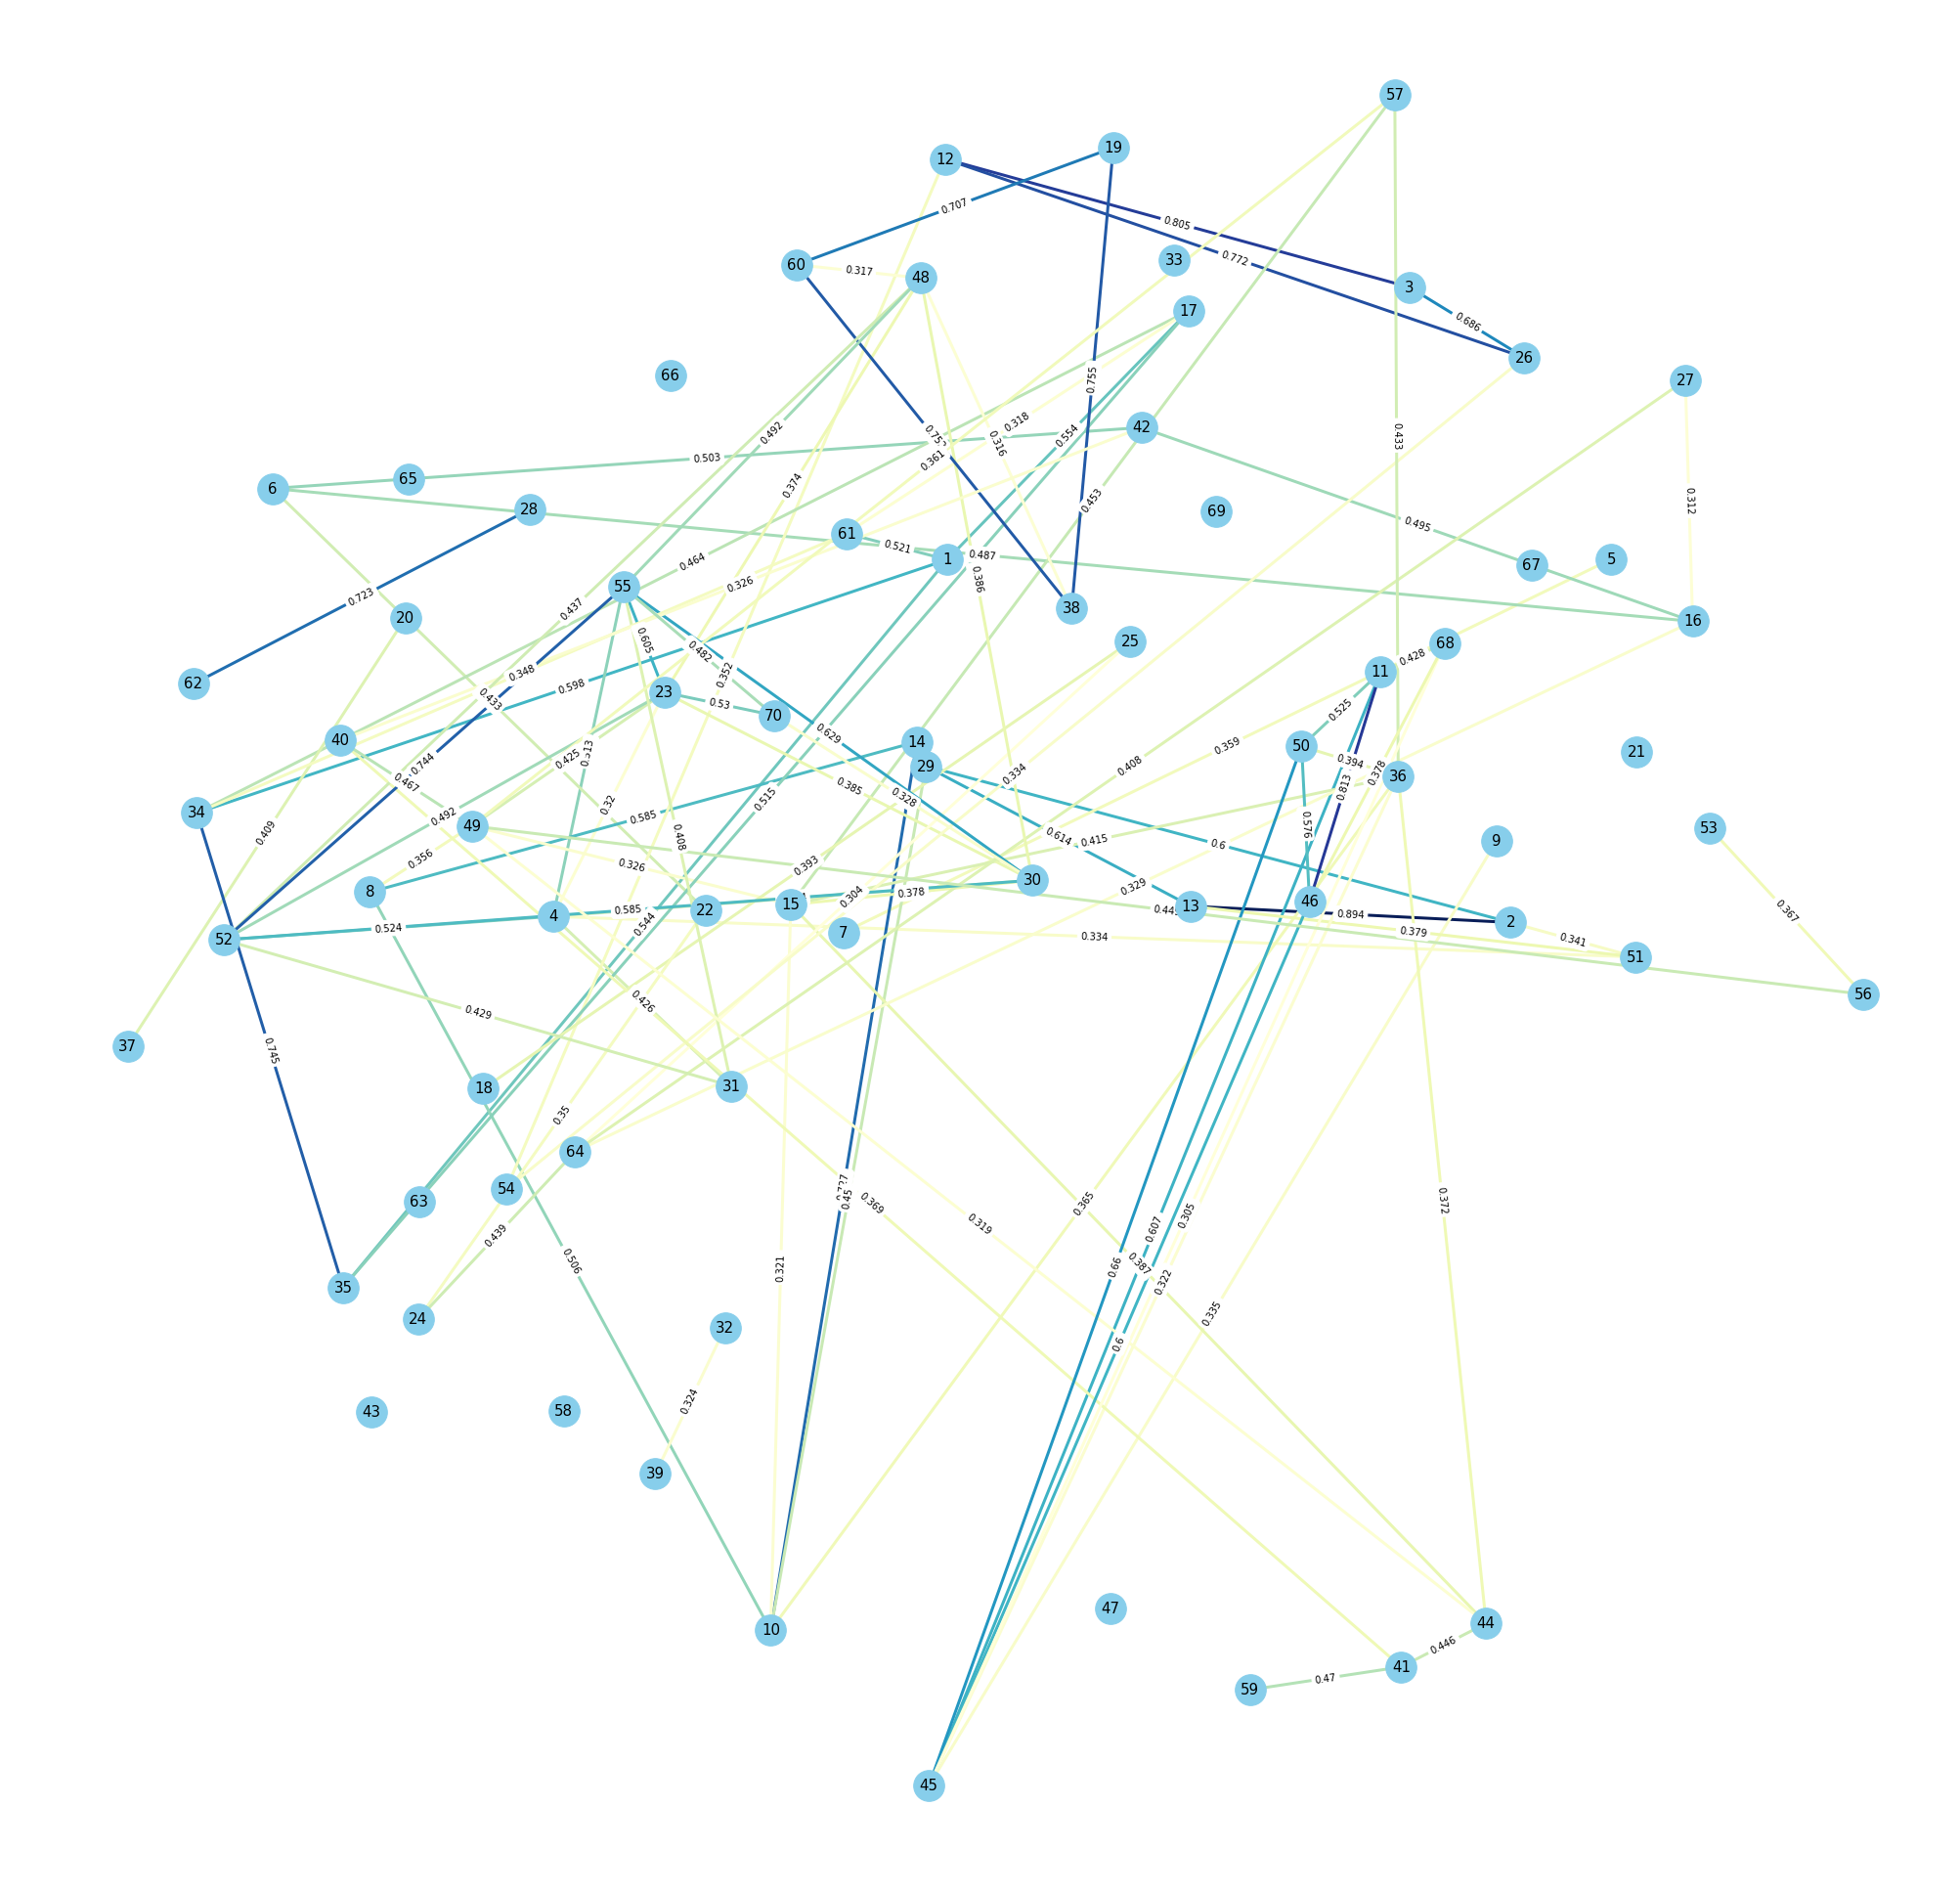

In [8]:
drd87_total_graph = NeuronNetwork(drd87_fe.cell_transients_df)
pos = get_neuron_positions(drd87_total_graph, coordinates)
drd87_total_graph.plot(pos=pos, node_color="skyblue", figsize=(35, 35), node_size=1000)

### Next, we plot the network of neurons that were imaged in DRD87, for the entire duration of time spent in the **OpenArms** during the EPM experiment.

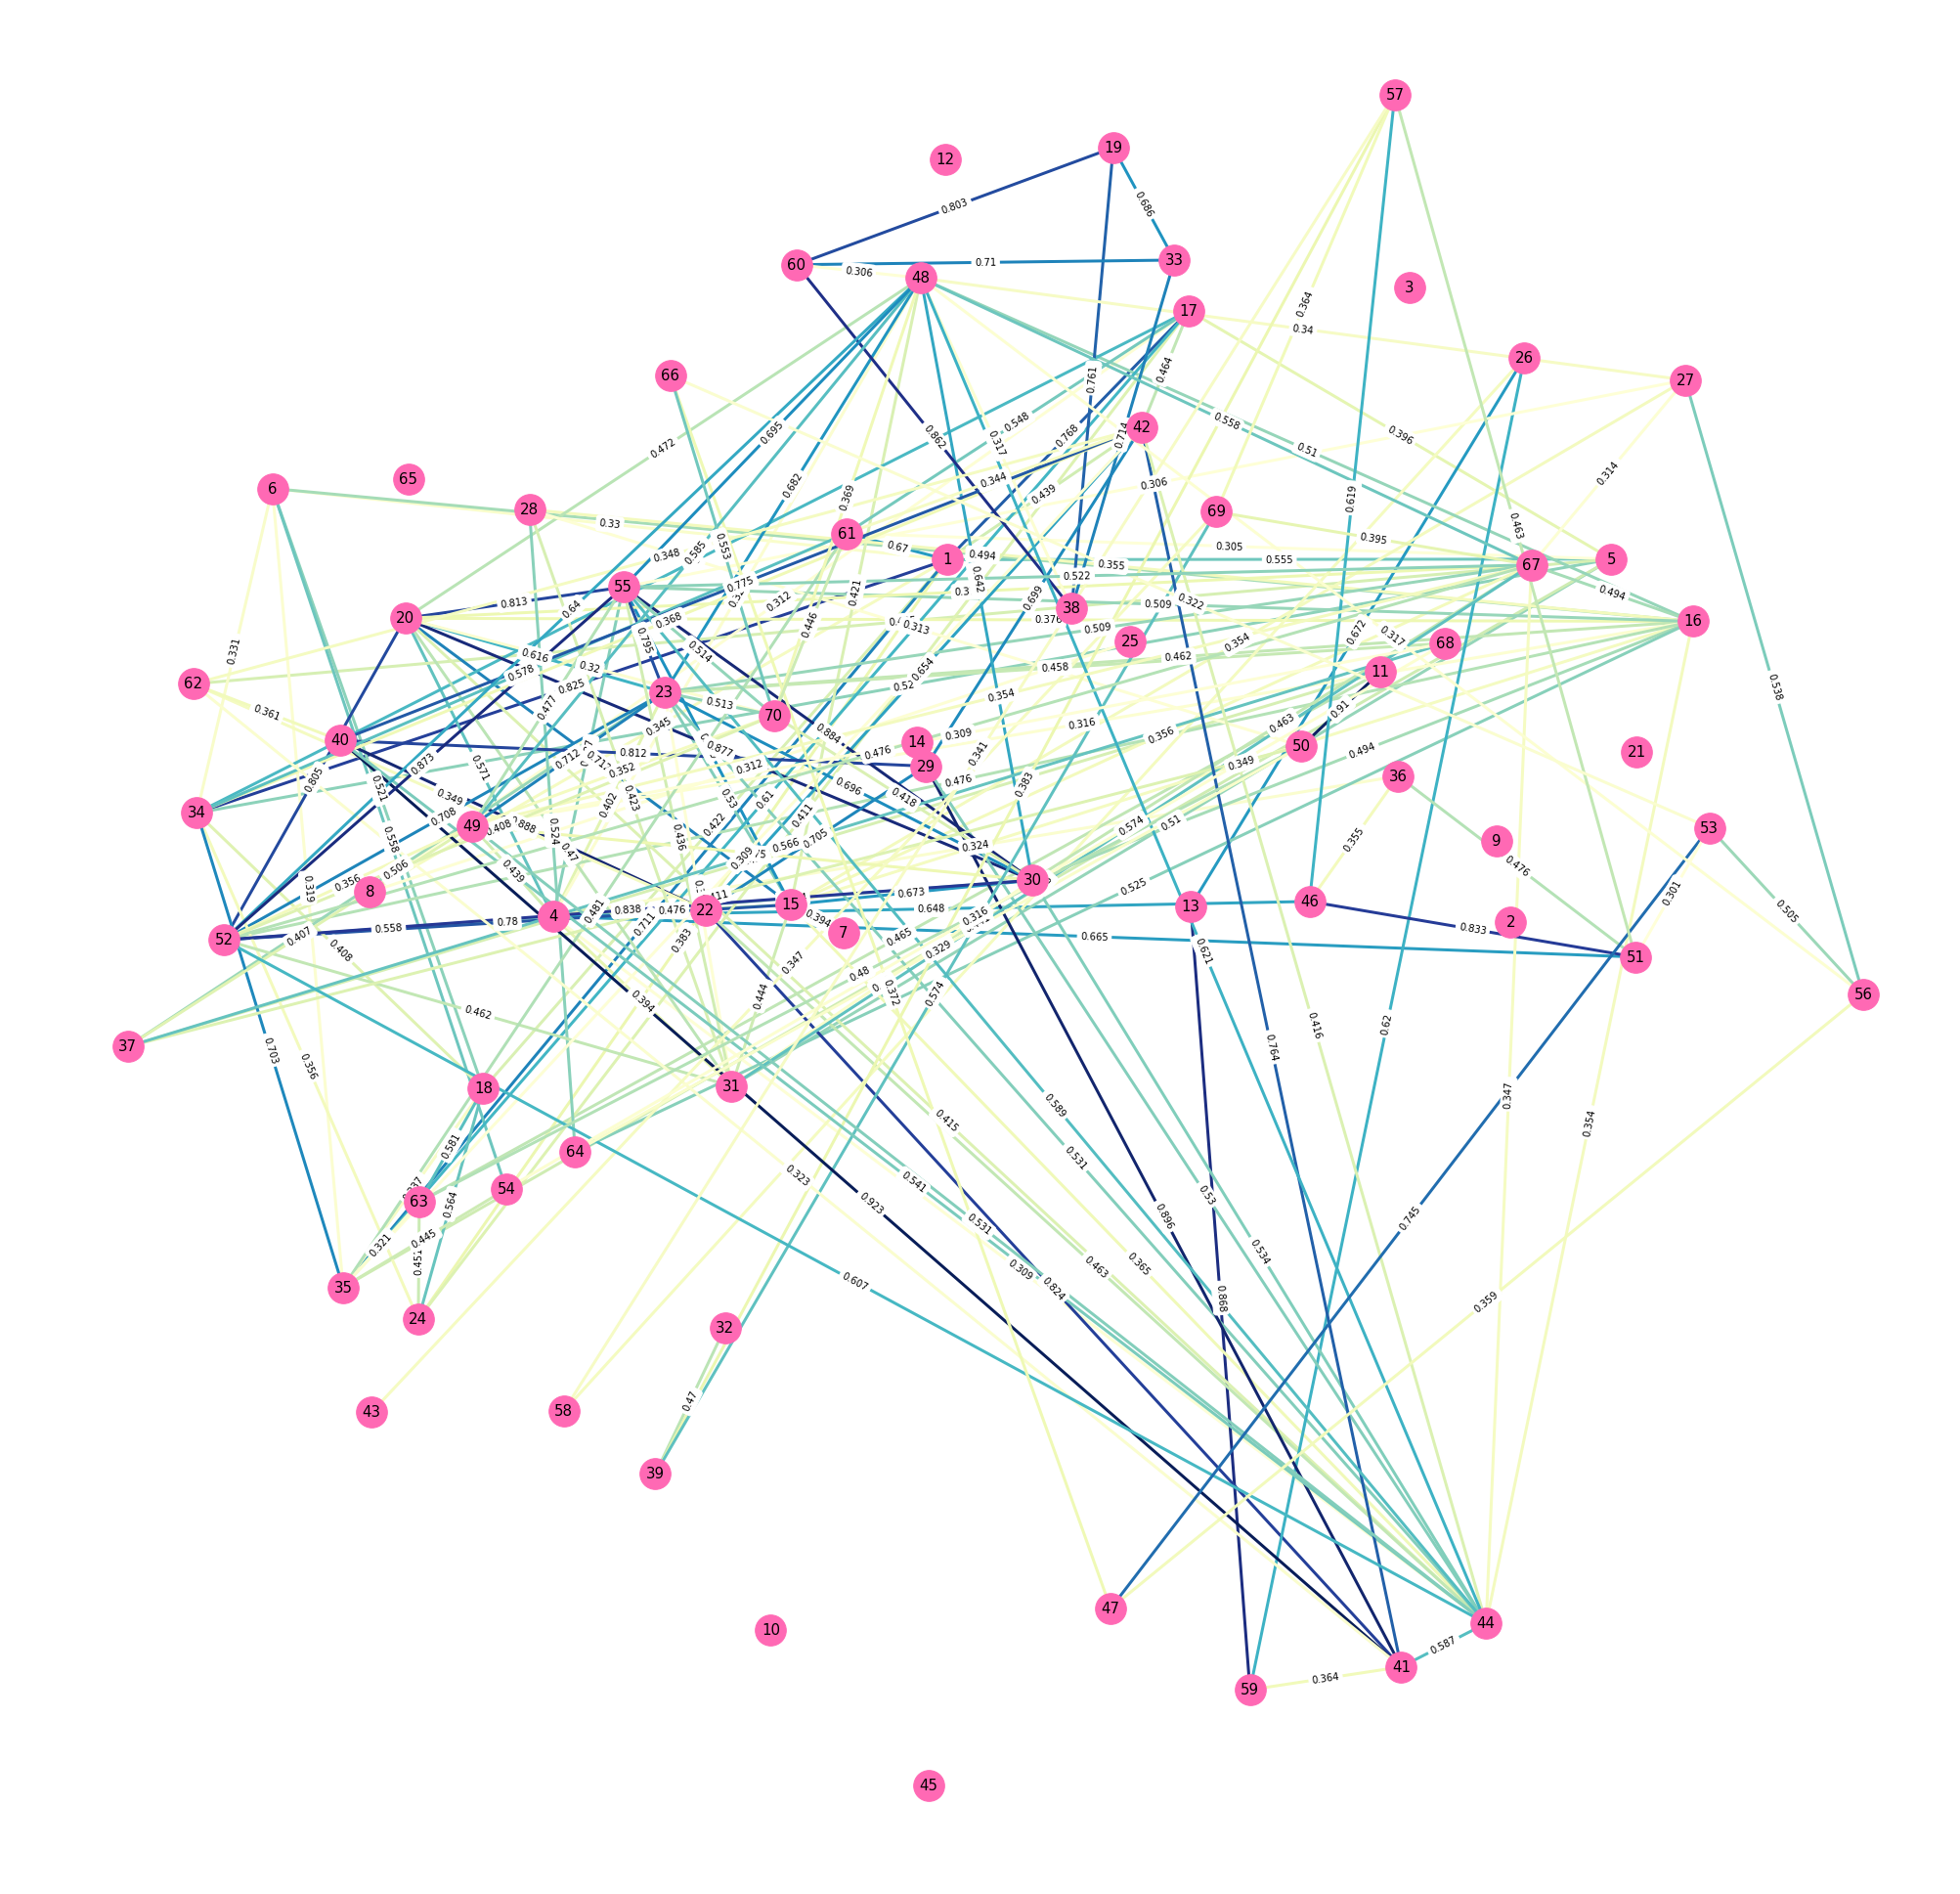

In [9]:
drd87_open_arms_graph = get_behavior_graph(drd87_fe, "OpenArms_centerpoint")
drd87_open_arms_graph.plot(pos=pos, node_color="hotpink", figsize=(35, 35), node_size=1000, save=True, file_name="overall_open.png")

### Finally, we plot the network of neurons that were imaged in DRD87, for the entire duration of time spent in the **ClosedArms** during the EPM experiment.

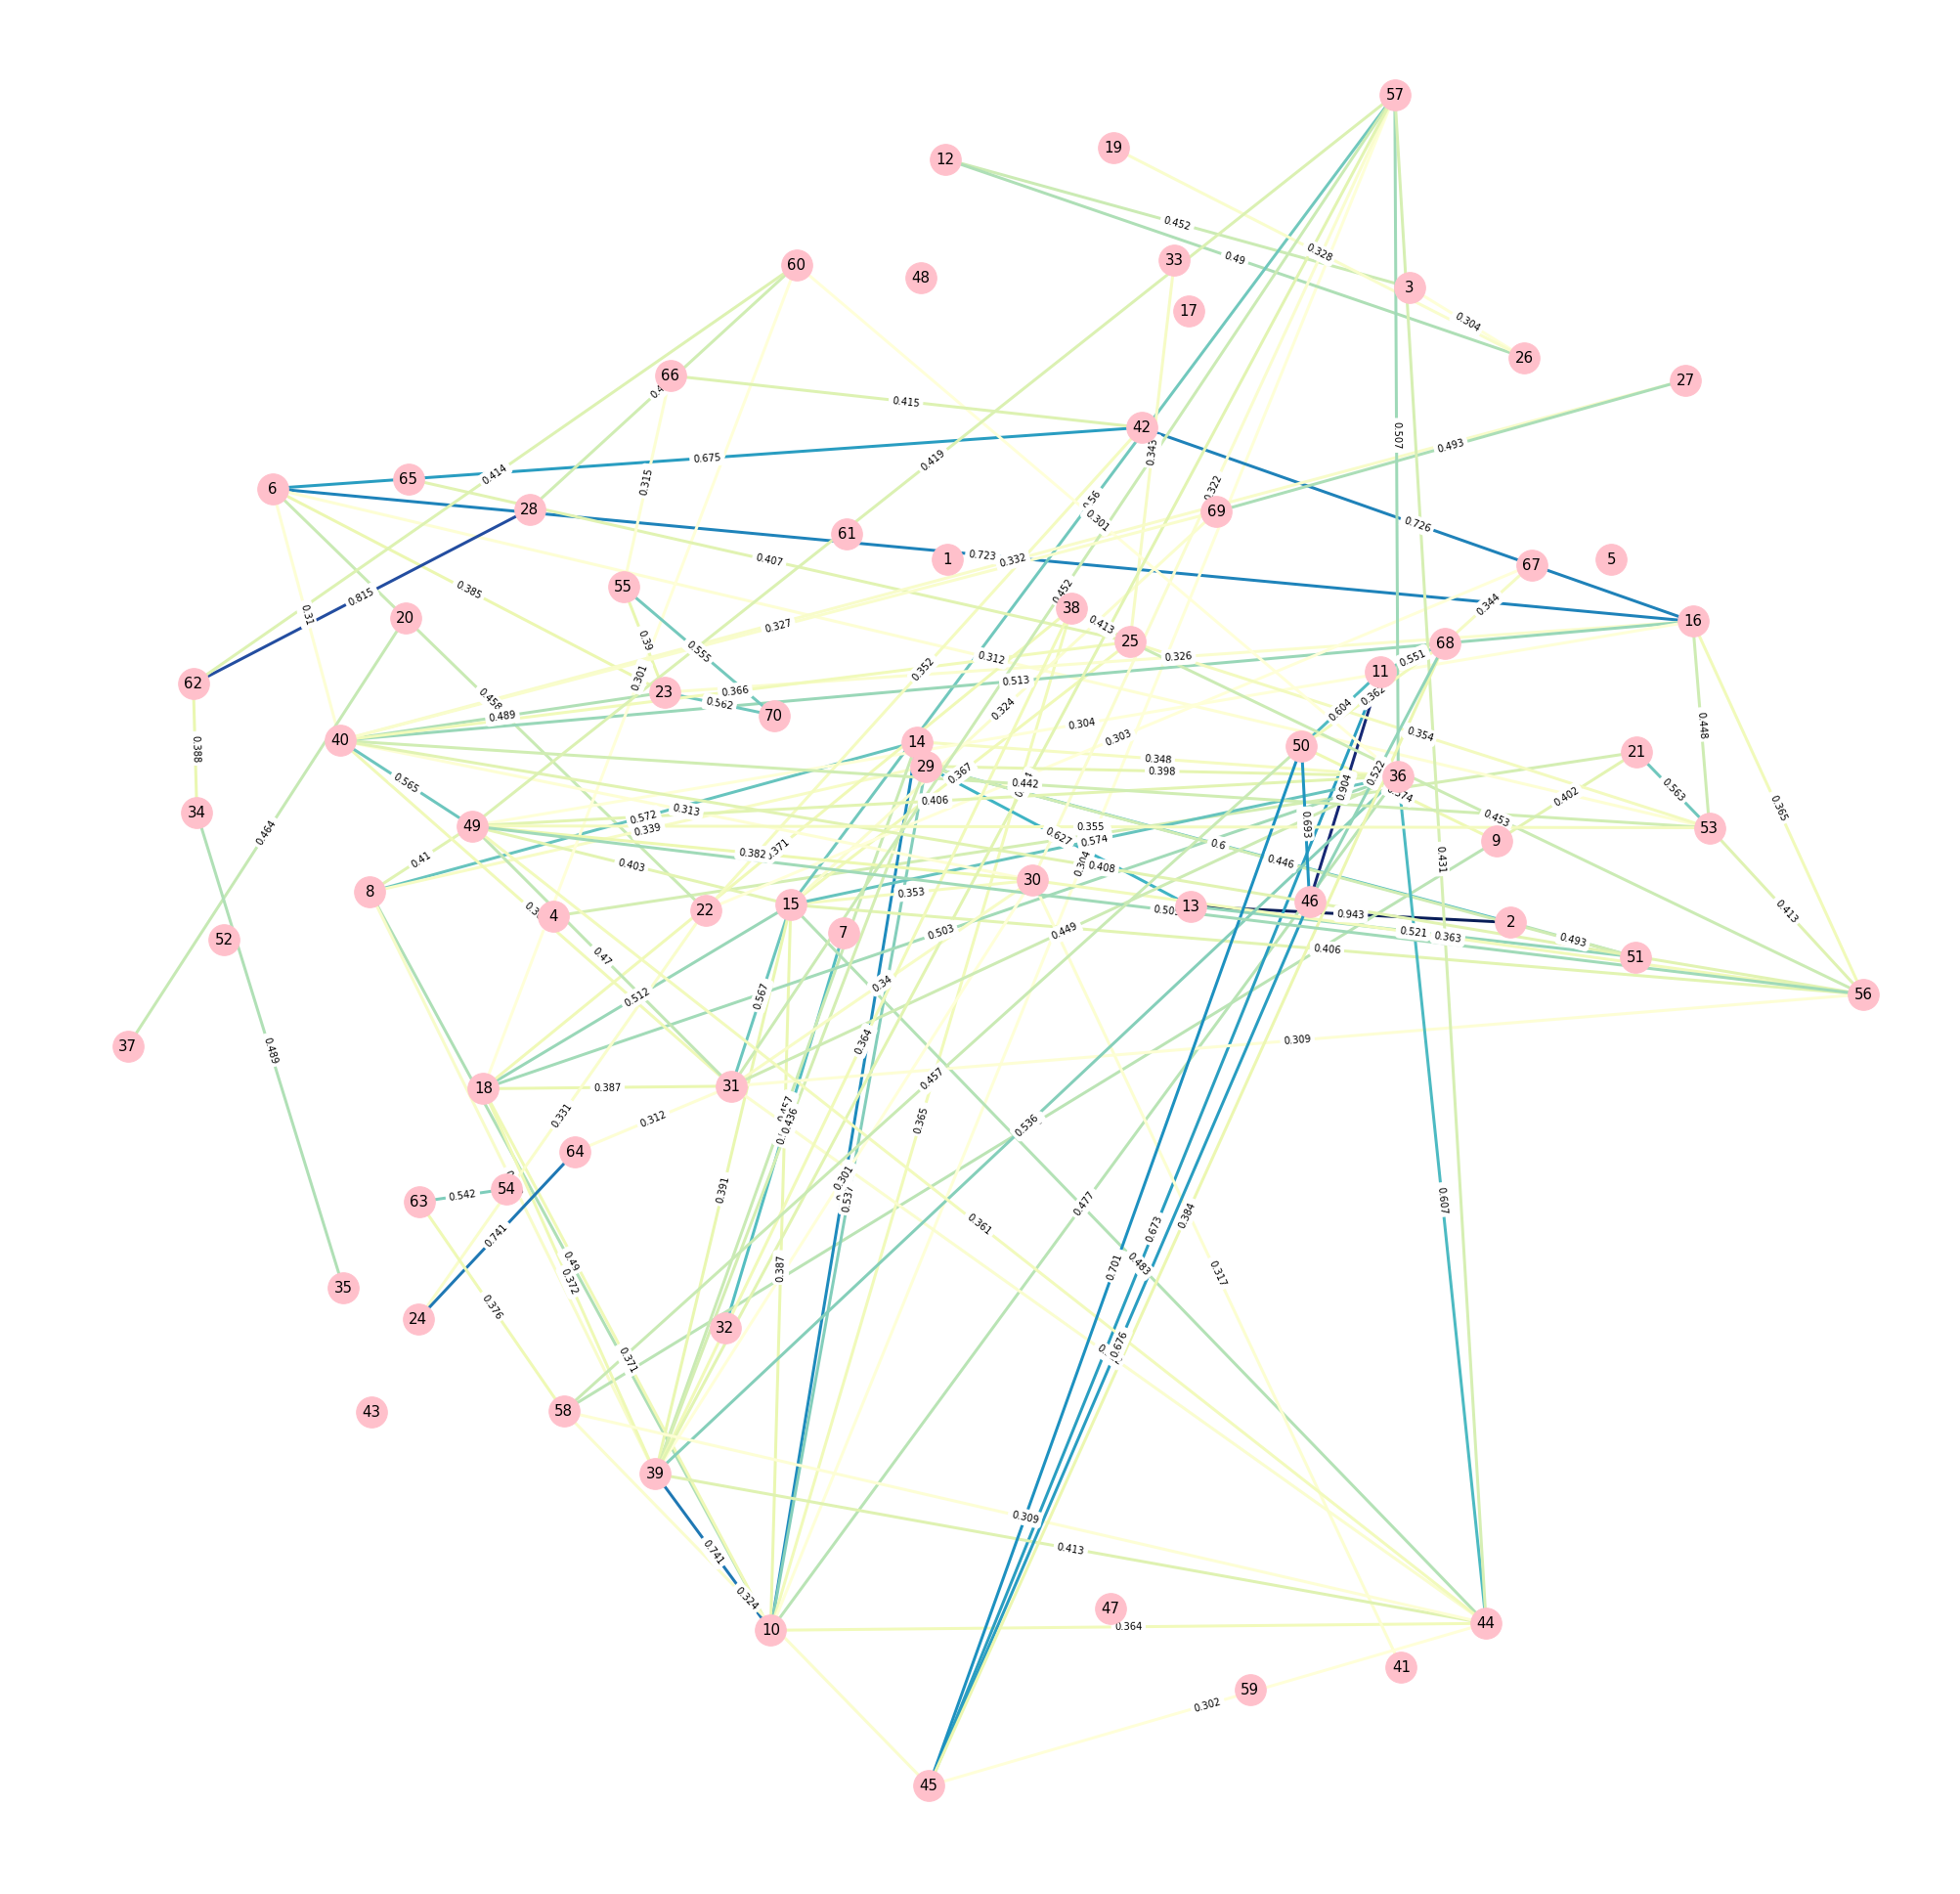

In [10]:
drd87_closed_arms_graph = get_behavior_graph(drd87_fe, "ClosedArms_centerpoint")
drd87_closed_arms_graph.plot(pos=pos, node_color="pink", figsize=(35, 35), node_size=1000, save=True, file_name="overall_closed.png")

# Now we compute and plot all of the network measures (of interest), for each mouse.

In [11]:
import matplotlib.pylab as plt

def quick_bar_plot(y1, y2, **kwargs):
    figsize = kwargs.get("figsize", (6, 5))
    fig, ax = plt.subplots(figsize=figsize)

    index = np.arange(1)
    bar_width = 0.35
    opacity = 0.4
    rects1 = ax.bar(index, tuple(y1), bar_width, alpha=opacity, color='b', label="Open Arms")
    rects2 = ax.bar(index + bar_width, tuple(y2), bar_width, alpha=opacity, color='r', label="Closed Arms")

    # ax.set_xlabel("DRD87")
    ylabel = kwargs.get("ylabel", "Measure")
    ax.set_ylabel(ylabel)
    title = kwargs.get("title", "Title Goes Here")
    ax.set_title(title)
    ax.set_xticks([])
    ax.legend();
    fig.tight_layout();
    plt.show();

### *Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other nodes pairs in the network pass through it. A node with high centrality is thus cruciail to efficinet communication.* (Bullmore and Sporns)

### We took take the mean of the degree centrality of all the nodes in the networks of interest. As we can see, the mean degree centrality of the networks is higher when the mice were in the open arms of the EPM.

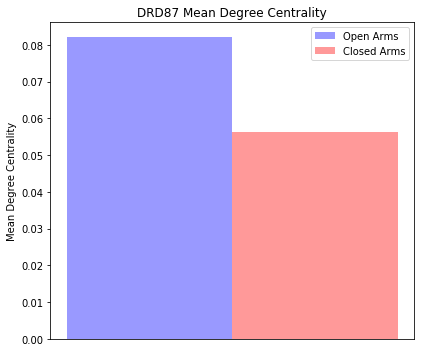

In [12]:
open_measures = [drd87_open_arms_graph.mean_degree_centrality] 
closed_measures = [drd87_closed_arms_graph.mean_degree_centrality]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Mean Degree Centrality", ylabel="Mean Degree Centrality", figsize=(6, 5))

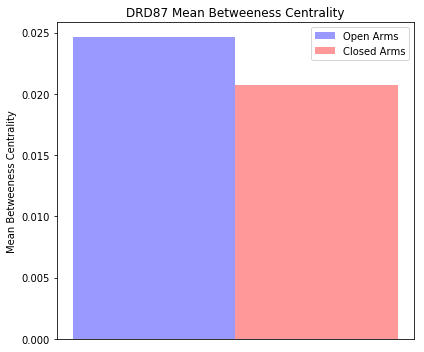

In [13]:
open_measures = [drd87_open_arms_graph.mean_betw_centrality] 
closed_measures = [drd87_closed_arms_graph.mean_betw_centrality]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Mean Betweeness Centrality", ylabel="Mean Betweeness Centrality", figsize=(6, 5))

### *Connection density is the actual number of edges in the graph as a proportion of the total number of possible edges and is the simplest estimator of the physical cost — for example, the energy or other resource requirements — of a network.* (Bullmore and Sporns)

### As one would expect, the connection density is greater when the mice were in the open arms of the EPM.

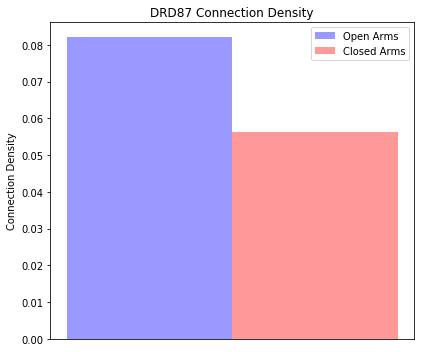

In [14]:
open_measures = [drd87_open_arms_graph.connection_density] 
closed_measures = [drd87_closed_arms_graph.connection_density]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Connection Density", ylabel="Connection Density", figsize=(6, 5))

### *If the nearest neighbors of a node are also directly connected to each other they form a cluster. The clustering coefficient quantifies the number of connections that exist between the nearest neighbors of a node as a proportion of the maximum number of possible connections. Random networks have lowe average clustering whereas complex networks have high clustering (associated with high local efficiency of information transfer and robustness).* (Bullmore and Sporns)

### As shown below, the clustering coefficient for all the networks was greater when the mice were in the open arms of the EPM.

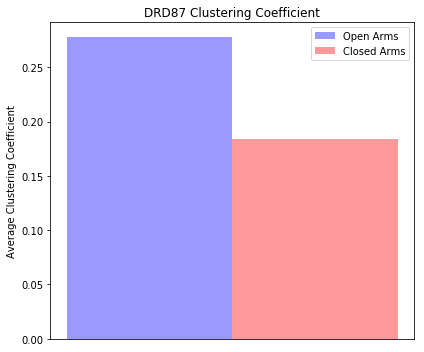

In [15]:
open_measures = [drd87_open_arms_graph.clustering_coefficient] 
closed_measures = [drd87_closed_arms_graph.clustering_coefficient]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Clustering Coefficient", ylabel="Average Clustering Coefficient", figsize=(6, 5))

### *The 'small-world' property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of a network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections - mostly within a clique of neighbours.* (Bullmore and Sporns)

### As shown below, we computed the mean clique size, as well as the maximum clique size, in all networks of interest. We observe that larger cliques of neurons were formed when the mice were in the open arms of the EPM.

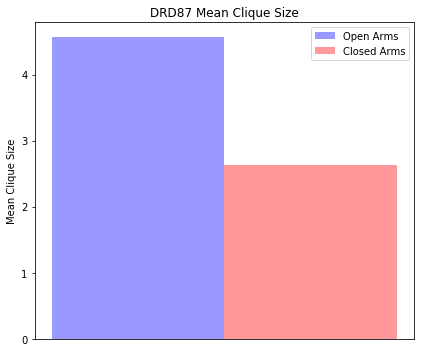

In [16]:
open_measures = [drd87_open_arms_graph.mean_clique_size] 
closed_measures = [drd87_closed_arms_graph.mean_clique_size]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Mean Clique Size", ylabel="Mean Clique Size", figsize=(6, 5))

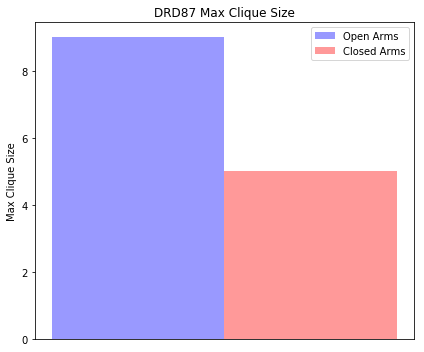

In [17]:
open_measures = [drd87_open_arms_graph.max_clique_size] 
closed_measures = [drd87_closed_arms_graph.max_clique_size]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Max Clique Size", ylabel="Max Clique Size", figsize=(6, 5))

### *Path length is the minimum number of edges that must be traversed to go from one node to another. Random and complex networks have short mean path lengths (high global efficiency of parallel information transfer) whereas regular lattices have long mean path lengths. Efficiency is inversely related to path length but is numerically easier to use to estimate topological distances between elements of disconnected graphs.* (Bullmore and Sporns)

### We compute the global efficiency of all networks of interest, and we find that global efficiency was greater when the mice were in the open arms of the EPM.

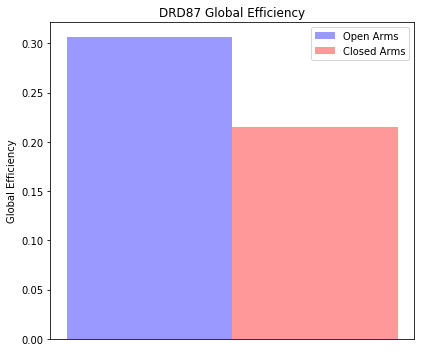

In [18]:
open_measures = [drd87_open_arms_graph.global_efficiency] 
closed_measures = [drd87_closed_arms_graph.global_efficiency]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Global Efficiency", ylabel="Global Efficiency", figsize=(6, 5))

#### Originally described in social networks, the ‘small-world’ property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of the network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections — mostly within a clique of neighbours. Small-world organization is intermediate between that of random networks, the short overall path length of which is associated with a low level of local clustering, and that of regular networks or lattices, the high-level of clustering of which is accompanied by a long path length. A convenient single-number summary of small-worldness is thus the ratio of the clustering coefficient to the path length after both metrics have been standardized by comparing their values to those in equivalent random networks (Bullmore and Sporns 2009).

#### We will compare the (null) distribution of [global efficiency] estimated in random networks containing the same number of nodes and connections. Statistical testing of this network measure will be carried out via resampling.

### We define average path length, L, as the average length of the shortest path connecting any pair of nodes in a network. (Yu et al. 2008)

In [19]:
def compute_avg_shortest_path_len(graph):
    shortest_path_lengths = list()
    node_list = list(graph.nodes)
    
    for i in range(0, len(node_list)):
        for j in range(i+1, len(node_list)):
            source = node_list[i]
            target = node_list[j]
            if not nx.has_path(graph, source, target):
                continue

            shortest_path_lengths.append(nx.shortest_path_length(graph, source=source, target=target, weight="weight"))
    
    return np.mean(shortest_path_lengths)

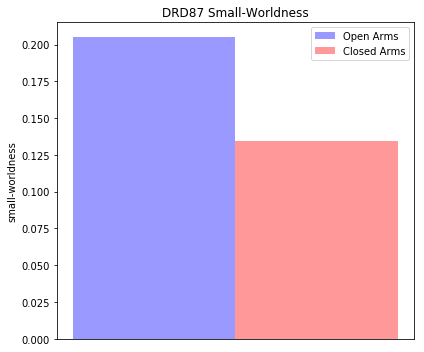

In [20]:
open_arms_small_worldness = drd87_open_arms_graph.clustering_coefficient / compute_avg_shortest_path_len(drd87_open_arms_graph.network)
closed_arms_small_worldness = drd87_closed_arms_graph.clustering_coefficient / compute_avg_shortest_path_len(drd87_closed_arms_graph.network)

open_measures = [open_arms_small_worldness] 
closed_measures = [closed_arms_small_worldness]
quick_bar_plot(open_measures, closed_measures, title="DRD87 Small-Worldness", ylabel="small-worldness", figsize=(6, 5))

In [21]:
def plot_random_graph(random_graph):
    # Size of the plot
    plt.figure(figsize=(35, 35))

    # nodes
    node_size = 1000
    color = "pink"
    nx.draw_networkx_nodes(random_graph, pos, node_size=node_size, node_color=color)

    edges, weights = zip(*nx.get_edge_attributes(random_graph, "weight").items())

    # edges
    nx.draw_networkx_edges(random_graph, pos, width=3.0, edge_color="lightgrey", edge_cmap=plt.cm.YlGnBu)

    labels = nx.get_edge_attributes(random_graph, "weight")
    nx.draw_networkx_edge_labels(random_graph, pos, edge_labels=labels)

    # labels
    font_size = 15
    nx.draw_networkx_labels(random_graph, pos, font_size=font_size, edge_labels=labels)

    plt.axis("off");
    plt.show();

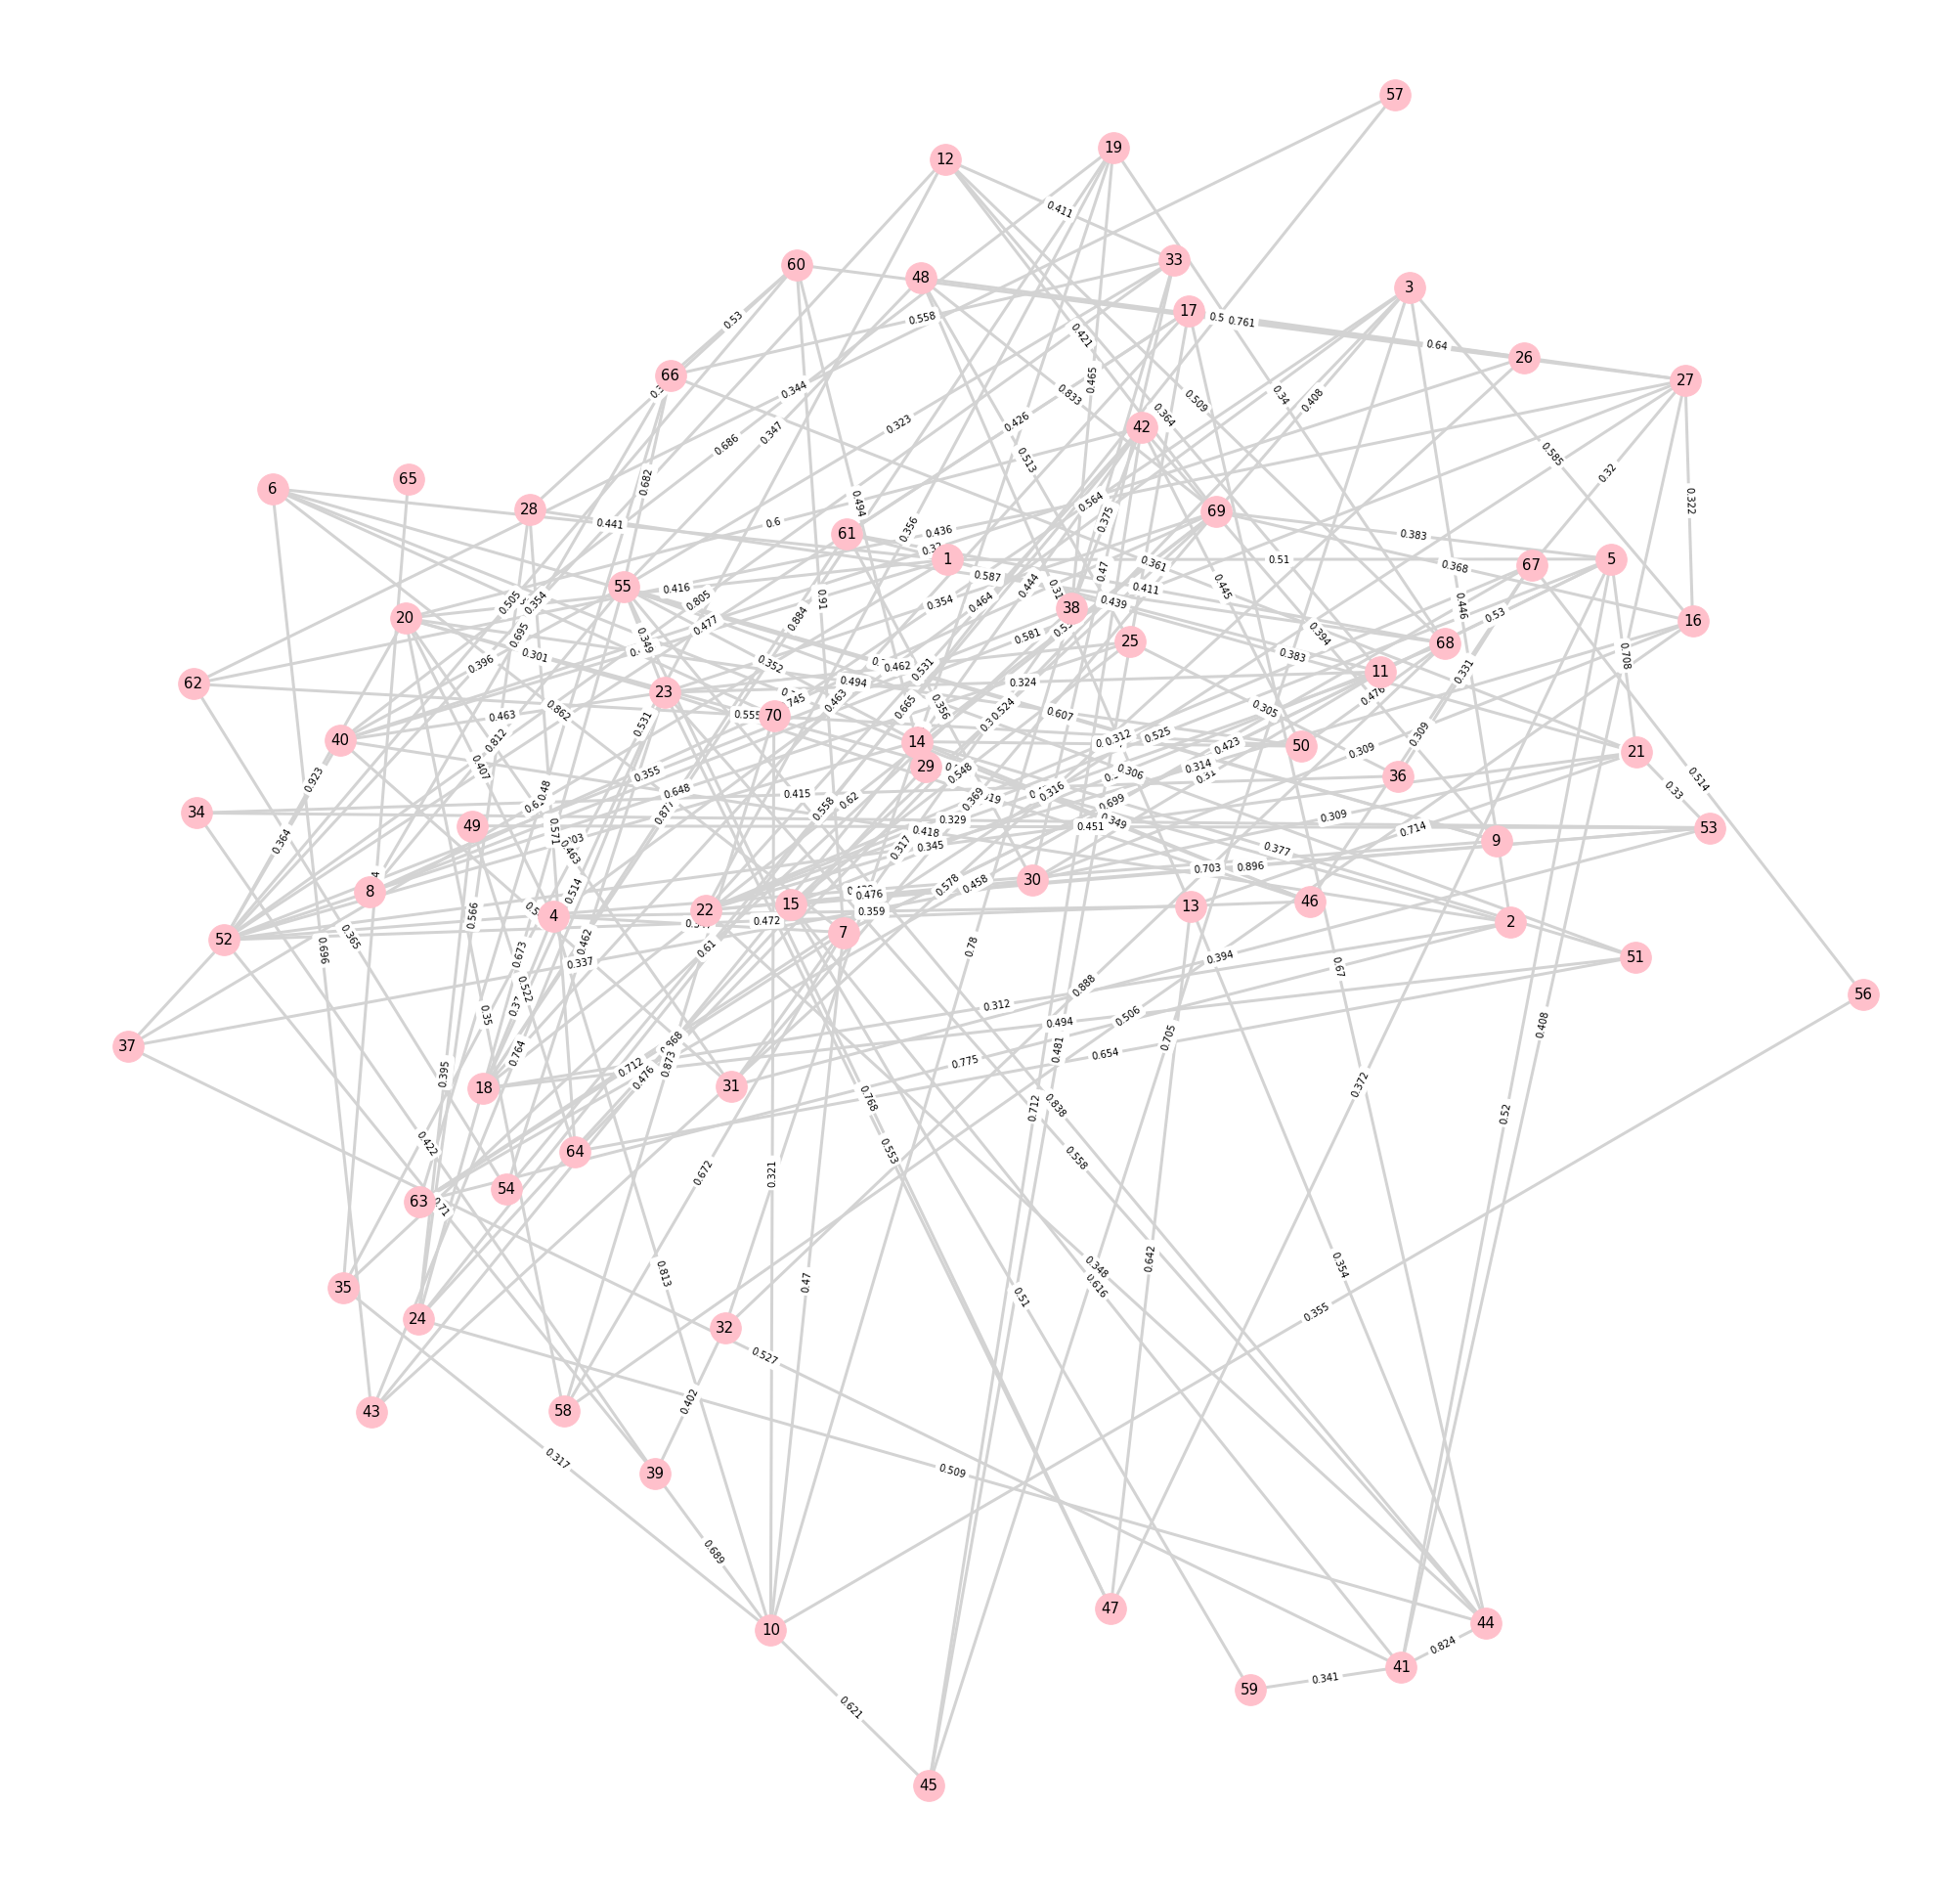

In [22]:
random_graph = drd87_open_arms_graph.generate_random_graph()
plot_random_graph(random_graph)

### Below, we plot the degree distribution of neurons in the actual **OpenArms** graph. Note that the degree distribution is clearly *not* Gaussian; however, the neuron degree distribution is also not a power-law distribution. 

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



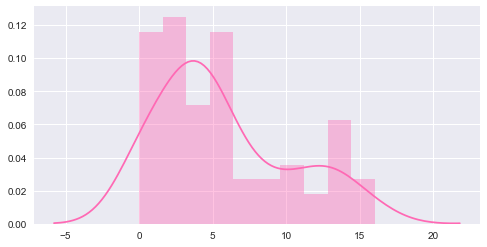

In [23]:
sns.set(rc={"figure.figsize": (8, 4)})
sns.distplot(list(dict(drd87_open_arms_graph.network.degree()).values()), color='hotpink', bins=10);

### Now, we plot the degree distribution of neurons in the actual **OpenArms** graph.

/anaconda3/envs/henlabenv/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



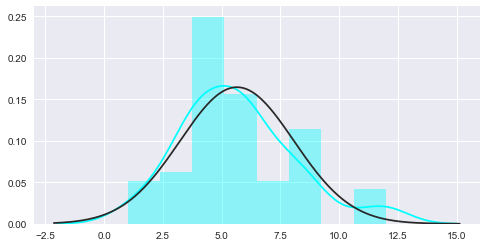

In [24]:
sns.set(rc={"figure.figsize": (8, 4)})
sns.distplot(list(dict(random_graph.degree()).values()), color='cyan', fit=stats.norm);

In [25]:
def bin_by_time(dataframe, **kwargs):
    """Split dataframe by frequency
    
    Split up the time series data into specified time bins. 
    
    Args: 
        dataframe: DataFrame
        
            a pandas DataFrame of the signal data for 
            all the imaged neurons of a given animal activity.
        
        freq: string, optional
            
            If specified, this is the frequency by which the 
            passed DataFrame will be split. The default is 
            1Min.
    
    Returns: 
        time_bins: dictionary
            
            All of the DataFrames that encompasse the passed-in
            DataFrame.
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = dataframe.copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta("0.1s")
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq=kwargs.get("freq", "1Min")))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    freq = 0
    for name, group in grouped:
        time_bins[freq] = grouped.get_group(name)
        freq += 1
        
    return time_bins

In [26]:
import networkx as nx

def get_continuous_beh_dataframes(neuron_network_obj, behavior, **kwargs):
    num_of_sec = kwargs.get("seconds", 5)
    framerate = kwargs.get("framerate", 10)
    dataframes = list()
    
    continuous_beh = dict()
    for row in neuron_network_obj.neuron_concated_behavior.itertuples():
        if getattr(row, behavior) == 1:
            continuous_beh[row[0]] = 1
        else:
            if len(continuous_beh) >= num_of_sec*framerate:
                
                # Note the start frame, and the end frame for when the animal entered the area.
                begin = list(continuous_beh.keys())[0]
                end = list(continuous_beh.keys())[len(list(continuous_beh.keys()))-1]
                print("Frames spent in {}: {}:{}".format(behavior, begin, end))
                
                dataframe = neuron_network_obj.auc_df.iloc[begin:end+1]
                dataframes.append(dataframe)

            continuous_beh.clear()
                
    return dataframes

In [27]:
open_arms_dataframes = get_continuous_beh_dataframes(drd87_fe, "OpenArms_centerpoint", seconds=1)
closed_arms_dataframes = get_continuous_beh_dataframes(drd87_fe, "ClosedArms_centerpoint", seconds=1)

Frames spent in OpenArms_centerpoint: 0:40
Frames spent in OpenArms_centerpoint: 76:116
Frames spent in OpenArms_centerpoint: 121:137
Frames spent in OpenArms_centerpoint: 190:225
Frames spent in OpenArms_centerpoint: 260:299
Frames spent in OpenArms_centerpoint: 308:328
Frames spent in OpenArms_centerpoint: 332:345
Frames spent in OpenArms_centerpoint: 903:971
Frames spent in OpenArms_centerpoint: 1127:1161
Frames spent in OpenArms_centerpoint: 1398:1431
Frames spent in OpenArms_centerpoint: 4022:4031
Frames spent in OpenArms_centerpoint: 5434:5538
Frames spent in OpenArms_centerpoint: 6116:6213
Frames spent in ClosedArms_centerpoint: 419:428
Frames spent in ClosedArms_centerpoint: 537:642
Frames spent in ClosedArms_centerpoint: 808:882
Frames spent in ClosedArms_centerpoint: 1072:1090
Frames spent in ClosedArms_centerpoint: 1169:1327
Frames spent in ClosedArms_centerpoint: 1531:1719
Frames spent in ClosedArms_centerpoint: 1744:1868
Frames spent in ClosedArms_centerpoint: 1903:2456
Fr

In [28]:
def sort_graphs_chronologically(feature_extractor, open_arms_dataframes, closed_arms_dataframes):
    i = 0
    j = 0
    graph_measures = list()
    markers_on = list()

    while i < len(open_arms_dataframes):
        if open_arms_dataframes[i].index.values[-1] < closed_arms_dataframes[j].index.values[-1]:
            graph = NeuronNetwork(open_arms_dataframes[i])
            graph_measures.append(graph.mean_degree_centrality)
            markers_on.append(len(graph_measures)-1)
            i += 1
        else:
            graph = NeuronNetwork(closed_arms_dataframes[j])
            graph_measures.append(graph.mean_degree_centrality)
            j += 1

    while j < len(closed_arms_dataframes):
        graph = NeuronNetwork(closed_arms_dataframes[j])
        graph_measures.append(graph.mean_degree_centrality)
        j += 1
    
    return graph_measures, markers_on

In [29]:
graph_measures, markers_on = sort_graphs_chronologically(drd87_fe, open_arms_dataframes, closed_arms_dataframes)

In [30]:
import matplotlib.pyplot as plt

def quick_plot(y_axis, figsize, color="blue", title="Title Goes Here", markevery=None):
    plt.figure(figsize=figsize)
    plt.plot(y_axis, color=color, marker='o', linestyle="solid", linewidth=1, markersize=7, markevery=markevery)
    plt.xlabel("Entry")
    plt.ylabel("Mean Degree Centrality")
    plt.title(title)
    plt.grid(True)
    plt.show();

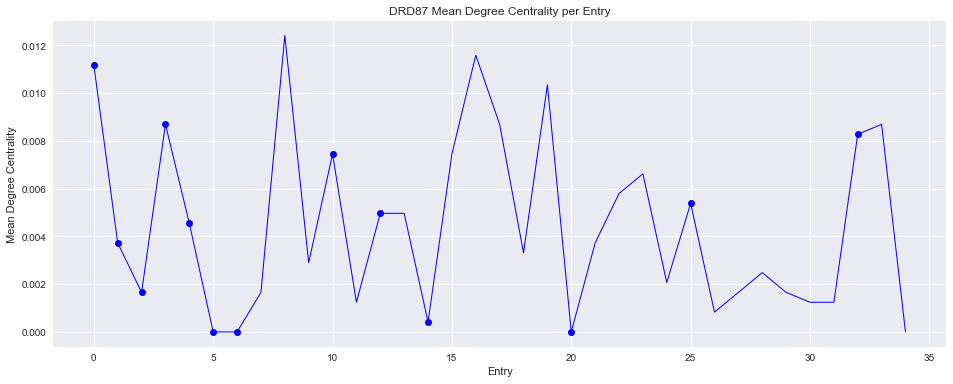

In [31]:
quick_plot(graph_measures, (16, 6), color="blue", title="DRD87 Mean Degree Centrality per Entry", markevery=markers_on)

## We are interested in a scatter plots that show rate vs. degree, as follows:
* in entire session, just open, and just closed
* color coding open selective cells
* The idea here is to see whether more active neurons on average have more correlated pairs

In [32]:
drd87_real_diff_vals = drd87_fe.set_real_diff_df(drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
drd87_real_diff_vals

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:106: Warning:

Frame rate wasn't specified, so frame rate will be set to 10



neuron1  neuron2  neuron3  neuron4   neuron5  neuron6 neuron7 neuron8  \
D  5.72857 -3.00185 -1.36973  12.1606 -0.555661 -3.64355  8.0656 -3.7702   

    neuron9 neuron10   ...    neuron61 neuron62  neuron63  neuron64 neuron65  \
D -0.683886 -3.68069   ...     3.74837 -0.92522  0.176564  0.569157 -1.74818   

   neuron66 neuron67 neuron68 neuron69 neuron70  
D  0.711728  1.67555  1.55181  1.89085  4.47428  

[1 rows x 70 columns]

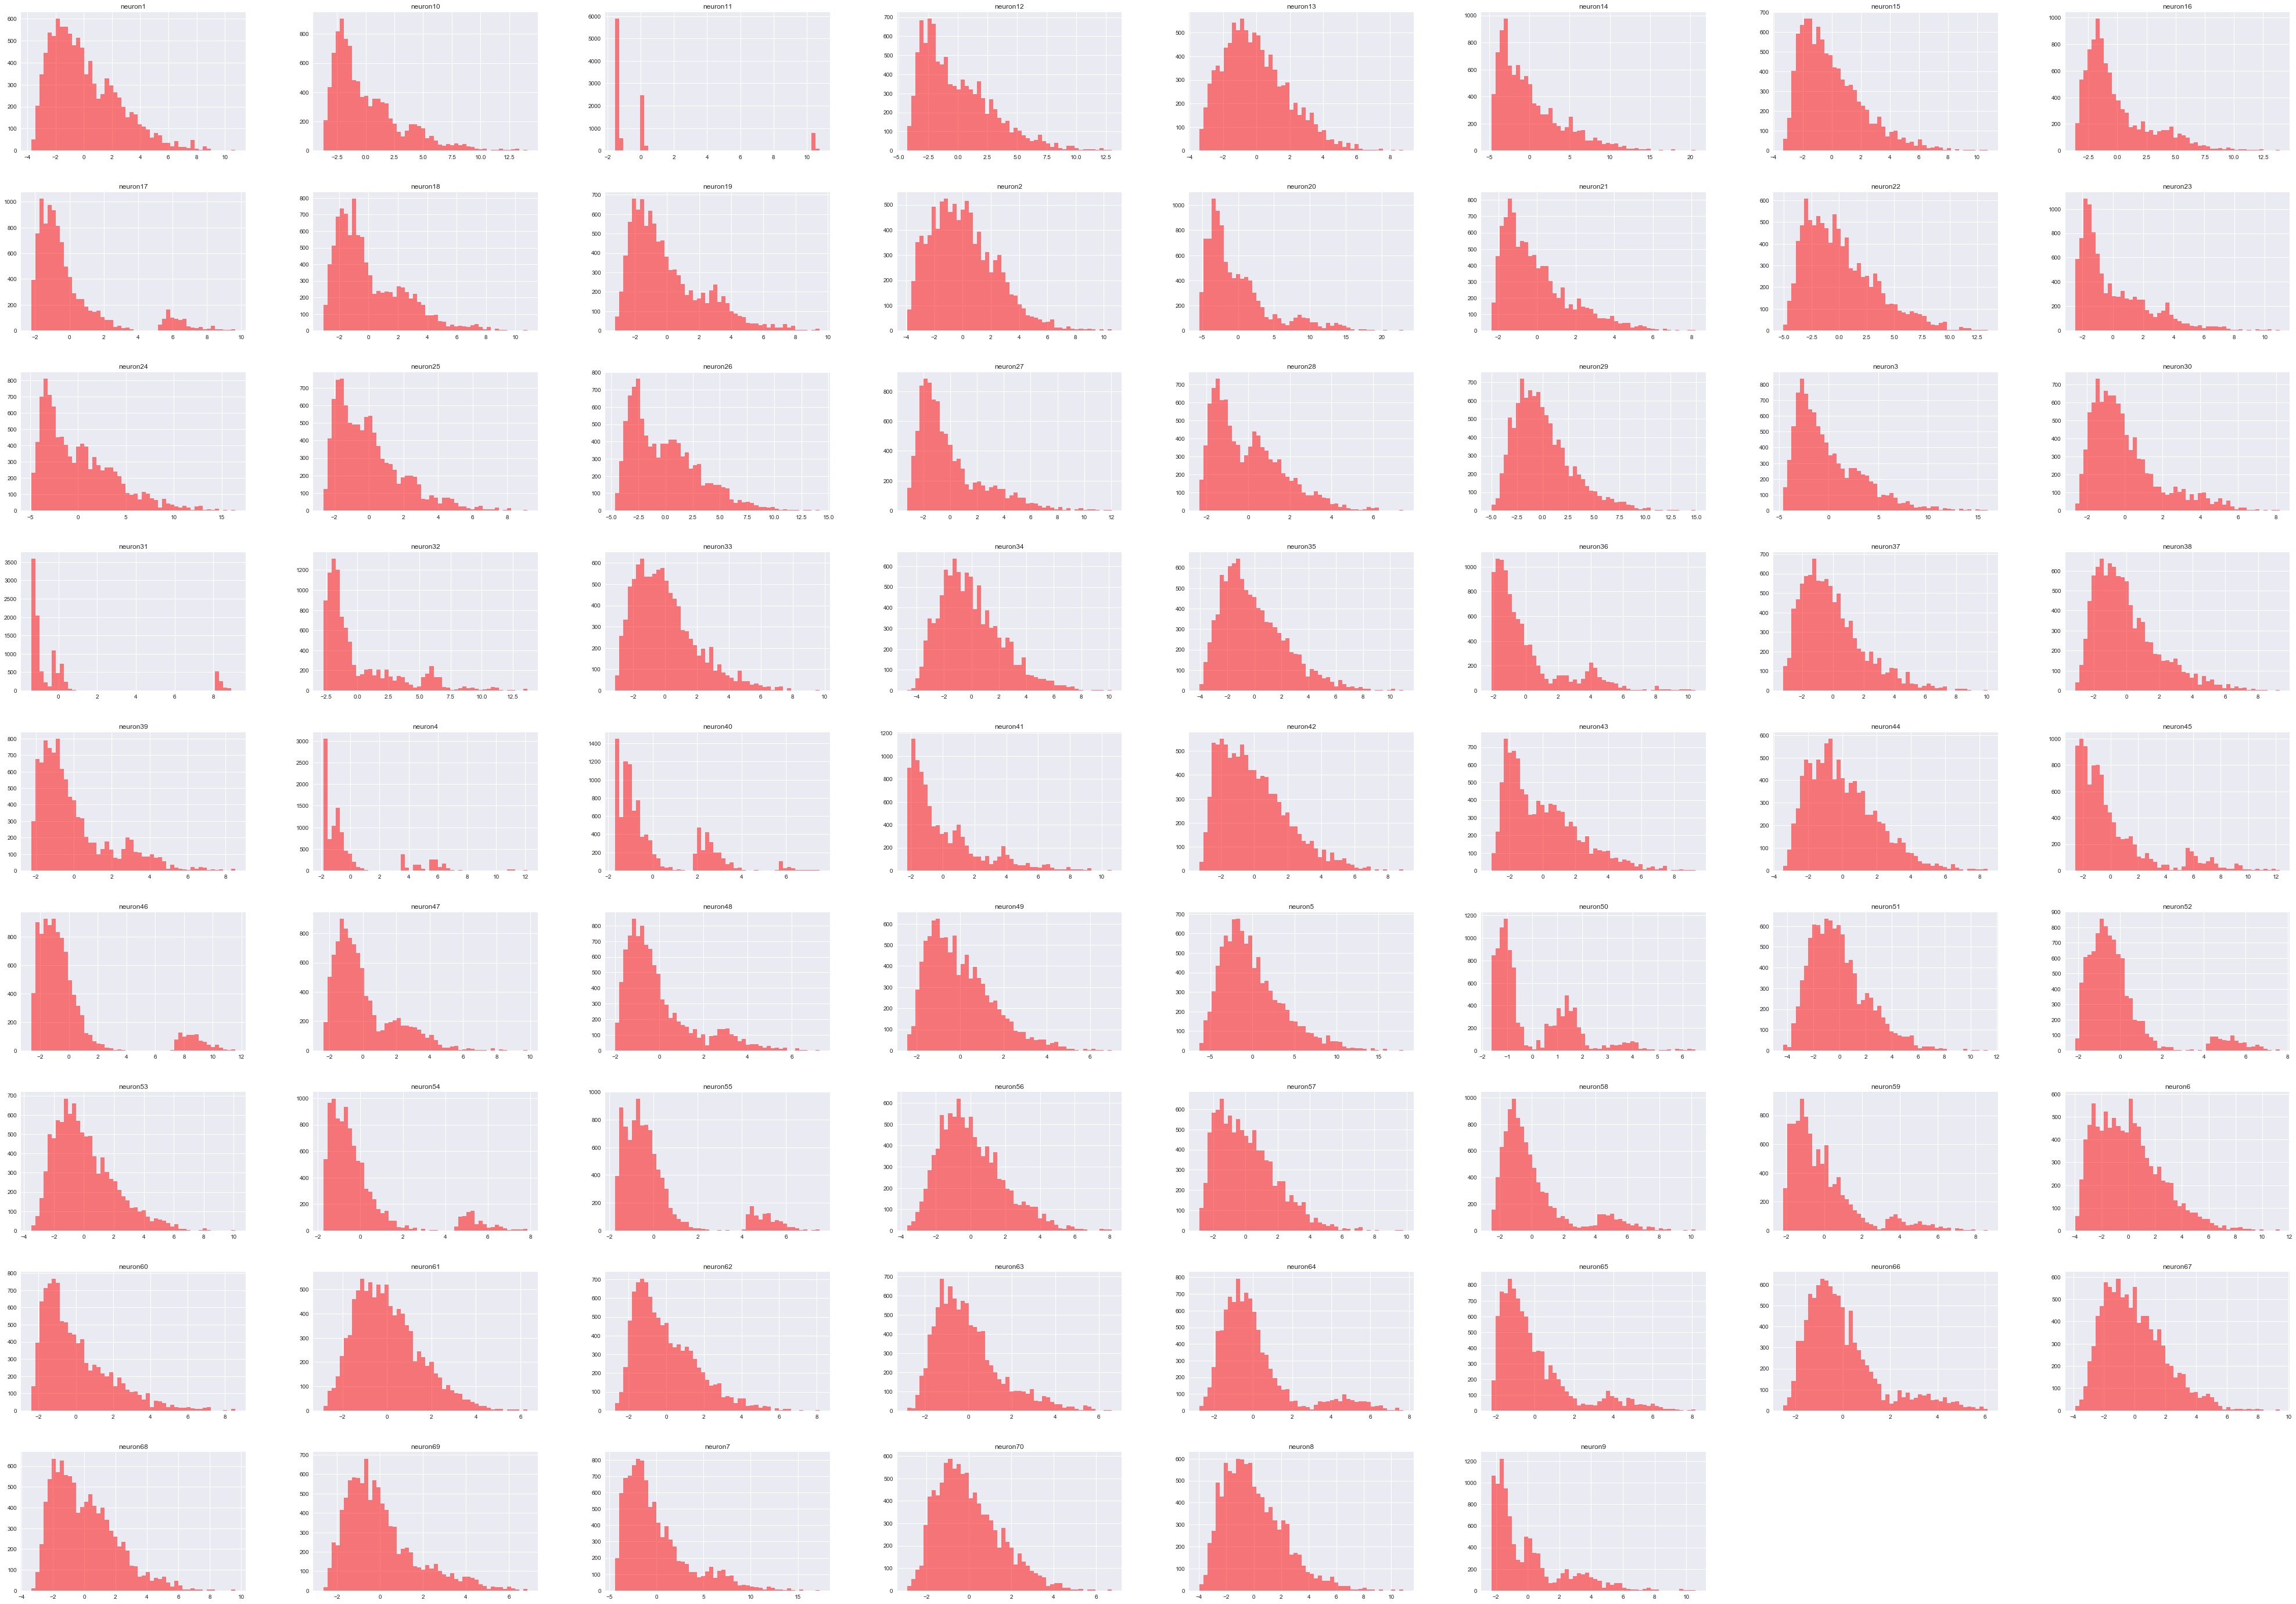

In [33]:
resampled_df = Resampler.shuffle(10000, drd87_fe.neuron_concated_behavior, drd87_fe.auc_df.columns, "OpenArms_centerpoint", "ClosedArms_centerpoint")
resampled_df.hist(alpha=0.5, color="red", bins=50, figsize=(70, 50));

In [34]:
drd87_classified_neurons = Resampler.non_normal_neuron_classifier(drd87_fe.auc_df, resampled_df, drd87_real_diff_vals, p_value=0.1, threshold=5)
drd87_neurons_by_beh = Resampler.classify_by_behavior(drd87_classified_neurons, drd87_real_diff_vals, "OpenArms_centerpoint", "ClosedArms_centerpoint")

#### We use the function, `activity_rates()`, defined below, in order to get a dictionary of the average activity rate, for each neuron. 

In [35]:
def activity_rates(feature_extractor, **kwargs):
    """Computes the neural activity rate of a given set of neurons.
    
    Args:
        feature_extractor: Feature_Extractor
        
        frame_rate: int, optional
        
        behavior: str, optional
    
    Returns:
        activity_rates: dictionary
            
    """
    frame_rate = kwargs.get("frame_rate", 10)
    behavior = kwargs.get("behavior")
    
    # Create shorthand name to avoid going over 80 line limit
    df = feature_extractor.neuron_concated_behavior
    
    activity_rates = dict()
    for neuron in feature_extractor.auc_df:
        if neuron not in activity_rates:
            if behavior:
                rate = frame_rate * df.loc[df[behavior] != 0, neuron].mean()
                activity_rates[neuron] = rate
            else:
                rate = frame_rate * df.loc[:, neuron].mean()
                activity_rates[neuron] = rate
    
    return activity_rates

### We begin by attaining the degree centrality for each neuron in the overall session, as well as the activity rate for each neuron in the overall session.

In [36]:
entire_session_degrees = nx.degree_centrality(drd87_total_graph.network)
entire_session_rates = activity_rates(drd87_fe)

#### We create a list of colors to color code **OpenArms**-selective neurons with red, and all other neurons with green.

In [37]:
RED = "rgb(250, 0, 0)"
GREEN = "rgb(0, 200, 0)"
colors = []
for neuron in list(entire_session_rates.keys()):
    if drd87_neurons_by_beh[neuron] == "OpenArms_centerpoint":
        colors.append(RED)
    else:
        colors.append(GREEN)

In [38]:
import plotly
import plotly.graph_objs as go 

def scatter_plot(x_axis, y_axis, point_names, **kwargs):
    title = kwargs.get("title", "Title Goes Here")
    colors = kwargs.get("colors", "rgb(0, 200, 0)")
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
    line = slope*np.asarray(x_axis) + intercept
    print("p_value for fit: {}".format(p_value))
    
    trace0 = go.Scatter(
        x = x_axis,
        y = y_axis,
        text = point_names,
        mode = "markers",
        name = "trace0",
        marker = dict(
            color = colors
        )
    )
    trace1 = go.Scatter(
        x=x_axis,
        y=line,
        mode='lines',
        marker=go.Marker(color="rgb(0, 0, 0)"),
        name='Fit'
    )
    data = [trace0, trace1]
    layout = go.Layout(
        width=700,
        height=700,
        title=title,
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [39]:
scatter_plot(list(entire_session_rates.values()), list(entire_session_degrees.values()), list(entire_session_rates.keys()), title="Degree Centrality vs. Activity Rate in Overall Session", color="rgb(135, 206, 250)", colors=colors)

p_value for fit: 0.12680311354010632


### Next, we compute the degree centrality for each neuron in the overall time spent in the **ClosedArms**, as well as the activity rate for each neuron in the overall time spent in the **ClosedArms**.

In [40]:
closed_arms_degrees = nx.degree_centrality(drd87_closed_arms_graph.network)
closed_arms_rates = activity_rates(drd87_fe, behavior="ClosedArms_centerpoint")

#### We create a list of colors to color code **OpenArms**-selective neurons with red, and all other neurons with green.

In [41]:
RED = "rgb(250, 0, 0)"
GREEN = "rgb(0, 200, 0)"
colors = []
for neuron in list(closed_arms_rates.keys()):
    if drd87_neurons_by_beh[neuron] == "OpenArms_centerpoint":
        colors.append(RED)
    else:
        colors.append(GREEN)

In [42]:
scatter_plot(list(closed_arms_rates.values()), list(closed_arms_degrees.values()), list(closed_arms_rates.keys()), title="Degree Centrality vs. Activity Rate in Closed Arms", colors=colors)

p_value for fit: 0.10012737433702734


### Finally, we compute the degree centrality for each neuron in the overall time spent in the **OpenArms**, as well as the activity rate for each neuron in the overall time spent in the **OpenArms**.

In [43]:
open_arms_degrees = nx.degree_centrality(drd87_open_arms_graph.network)
open_arms_rates = activity_rates(drd87_fe, behavior="OpenArms_centerpoint")

#### We create a list of colors to color code **OpenArms**-selective neurons with red, and all other neurons with green.

In [44]:
RED = "rgb(250, 0, 0)"
GREEN = "rgb(0, 200, 0)"
colors = []
for neuron in list(open_arms_rates.keys()):
    if drd87_neurons_by_beh[neuron] == "OpenArms_centerpoint":
        colors.append(RED)
    else:
        colors.append(GREEN)

In [45]:
scatter_plot(list(open_arms_rates.values()), list(open_arms_degrees.values()), list(open_arms_rates.keys()), title="Degree Centrality vs. Activity Rate in Open Arms", colors=colors)

p_value for fit: 0.017666498366291514


## For the sake of interest, we will also plot those per-entry network measures for just the **OpenArms**-selective neurons.

### First, we must utilize a permutation test in order to classify DRD87's imaged neurons.

In [ ]:
def sort_by_selectivity(graph, classifications):
    open_arms_nodes = list()
    closed_arms_nodes = list()
    unclassified_nodes = list()
    not_selective_nodes = list()

    for node in graph.nodes():
        if "{}{}".format("neuron", node) in classifications:
            if classifications["{}{}".format("neuron", node)] == "OpenArms_centerpoint":
                open_arms_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "ClosedArms_centerpoint":
                closed_arms_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "unclassified":
                unclassified_nodes.append(node)
            elif classifications["{}{}".format("neuron", node)] == "not-selective":
                not_selective_nodes.append(node)
                
    return open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes

In [ ]:
def plot_by_selectivity(graph, *node_lists, **kwargs):
    plt.figure(figsize=kwargs.get("figsize", (35,35)))
    
    pos = kwargs.get("pos", None)
    if pos is None:
        pos = nx.spring_layout(graph, weight="weight") 
    
    node_size = kwargs.get("node_size", 1000)
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[0], node_color="pink"); 
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[1], node_color="lightgreen");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[2], node_color="lightblue");
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, nodelist=node_lists[3], node_color="grey");

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    plt.axis("off");
    
    save_to_file = kwargs.get("save", False)
    if save_to_file:
        title = kwargs.get("file_name", "Graph.png")
        file_format = kwargs.get("format", "PNG")
        plt.savefig(title, format=file_format)
    
    plt.show();

### Now that we classified neurons by their selectivity using a permutation test, we can plot DRD87's network of neurons where all neurons are color-coded by their selectivity. We use the functions defined above the plot DRD87's network of neurons, where each neuron is color coded by its selectivity class. We plot the network of neurons in the **ClosedArms**, followed by the same network of neurons in the **OpenArms**.

- Legend:
 - Pink: OpenArms_centerpoint selective
 - Green: ClosedArms_centerpoint selective
 - Blue: Not selective
 - Grey: Unclassifiable

In [ ]:
open_arms_nodes, closed_arms_nodes, unclassified_nodes, not_selective_nodes = sort_by_selectivity(drd87_open_arms_graph.network, drd87_neurons_by_beh)
plot_by_selectivity(drd87_closed_arms_graph.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, pos=pos, save=False)
plot_by_selectivity(drd87_open_arms_graph.network, open_arms_nodes, closed_arms_nodes, not_selective_nodes, unclassified_nodes, pos=pos, save=False)

In [ ]:
import matplotlib.pylab as plt

def plot_by_color(graph, feature_func, **kwargs):
    feature_dict = feature_func(graph)

    plt.figure(figsize=kwargs.get("figsize", (35, 35)))

    pos = kwargs.get("pos", None)
    if pos is None:
        pos = nx.spring_layout(graph, weight="weight") 

    vmax = max(list(feature_dict.values()))
    vmin = min(list(feature_dict.values()))

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=1000, node_color=list(feature_dict.values()), cmap=plt.cm.cool, vmax=vmax, vmin=vmin);

    edges, weights = zip(*nx.get_edge_attributes(graph, "weight").items())

    # edges
    nx.draw_networkx_edges(graph, pos, width=3.0, edge_color=weights, edge_cmap=plt.cm.YlGnBu);

    labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=15, edge_labels=labels)

    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    plt.colorbar(sm)
    plt.axis('off');
    
    save_to_file = kwargs.get("save", False)
    if save_to_file:
        title = kwargs.get("file_name", "Graph.png")
        file_format = kwargs.get("format", "PNG")
        plt.savefig(title, format=file_format)

    plt.show();

### Using the `plot_by_color()` function, we plot DRD87's network of neurons during time spent in the **ClosedArms**, and time spent in the **OpenArms**. Note that neurons are colored by their corresponding degree centrality. In principle, one can provide any NetworkX function to color nodes by the figures that function produces, e.g., `nx.a` 

In [ ]:
plot_by_color(drd87_closed_arms_graph.network, nx.degree_centrality, figsize=(35, 35), pos=pos, save=False)
plot_by_color(drd87_open_arms_graph.network, nx.degree_centrality, figsize=(35, 35), pos=pos, save=False)